<a href="https://colab.research.google.com/github/RamyaGuru/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_ML_Magpie_AIMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Using Chemical Formula-based Descriptors

# Table of Contents

1. Load formation energy database from ``qmpy``
2. For each compound, fetch the chemical formula-based descriptors from ``magpie``
3. Define an example random forest regression model to predict formation energy
4. Perform grid search hyperparameter optimization to refine the random forest regression model
5. Compare the model performance for each case
6. Show the most important descriptors in the regression model

In [2]:
!pip install jarvis-tools lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 962 kB 8.2 MB/s 
     |████████████████████████████████| 325 kB 40.4 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from jarvis.ai.descriptors.elemental import get_element_fraction_desc
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from jarvis.ai.pkgs.utils import mean_absolute_deviation
from jarvis.ai.descriptors.cfid import get_chem_only_descriptors
%matplotlib inline
plt.rcParams.update({'font.size': 18})


For this notebook, we will utilize a set of formation energies made available through the ``qmpy`` package ([repo](https://github.com/wolverton-research-group/qmpy)), a toolkit developed alongside the ``OQMD`` database.

In [4]:
#Clone qmpy repository in order 
!git clone https://github.com/wolverton-research-group/qmpy.git

Cloning into 'qmpy'...
remote: Enumerating objects: 11291, done.
remote: Counting objects: 100% (994/994), done.
remote: Compressing objects: 100% (525/525), done.
remote: Total 11291 (delta 439), reused 963 (delta 429), pack-reused 10297
Receiving objects: 100% (11291/11291), 71.59 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (6569/6569), done.


In [5]:
import pandas as pd
energy_df = pd.read_csv('qmpy/qmpy/data/thermodata/legacy.dat', delimiter = " ")

energy_df[:10]

,composition,energy
0,Cl5Pb2Tl,-1.459858
1,Ga2MnSe4,-0.565283
2,Ag2Sn2Sr,-0.360284
3,Au2Si2Sr,-0.493980
4,Au2CaSi2,-0.485538
5,Ge2SrZn2,-0.366117
6,Cu2Ge2Sr,-0.373508
7,Co2Ge2Sr,-0.427252
8,CaCo2Ge2,-0.478208
9,F4NaTi,-3.371053


In [6]:
my_data = energy_df.values

**Collect the Chemical Formula Descriptors**

Here, we will get the information that will serve as the regressors in our model. NOTE: these descriptors are composition-based only. The descriptors consistute properties defined for specific elements (atomic mass, radius).

**Try Modifying**

The ``get_chem_only_descriptors`` function allows you to change the ``source`` of the descriptors. Change ``magpie`` to ``cfid`` to get an alternate set of descriptors. 

In [7]:
# Convert my_data to numpy array using CFID-Chem, Magpie and elemental fraction descriptors

X_cfid = []
X_Mag = []
X_elff = []

Y = []
IDs = []

for ii, i in enumerate(my_data):
    comp = i[0]
    desc_magpie,magpie_names = get_chem_only_descriptors(formula=comp, source="magpie")
    val = i[1]
    X_Mag.append(desc_magpie)
    Y.append(val)
    IDs.append(ii)
                
X_Mag = np.array(X_Mag)

Y = np.array(Y).reshape(-1, 1)

'''
Print out the mean absolute deviation, which captures the spread of values in
the target property distribution
'''
IDs = np.array(IDs)
mad = mean_absolute_deviation(Y)
print("MAD:", mad)


MAD: 0.7276698691263548


In [8]:
#Print out Magpie Chemical Formula Features
magpie_names[:30]

['Mean_magpie_AtomicWeight',
 'Mean_magpie_Column',
 'Mean_magpie_CovalentRadius',
 'Mean_magpie_Electronegativity',
 'Mean_magpie_GSbandgap',
 'Mean_magpie_GSmagmom',
 'Mean_magpie_GSvolume_pa',
 'Mean_magpie_MeltingT',
 'Mean_magpie_MendeleevNumber',
 'Mean_magpie_NUnfilled',
 'Mean_magpie_NdUnfilled',
 'Mean_magpie_NdValence',
 'Mean_magpie_NfUnfilled',
 'Mean_magpie_NfValence',
 'Mean_magpie_NpUnfilled',
 'Mean_magpie_NpValence',
 'Mean_magpie_NsUnfilled',
 'Mean_magpie_NsValence',
 'Mean_magpie_Number',
 'Mean_magpie_Row',
 'Mean_magpie_SpaceGroupNumber',
 'Max_magpie_AtomicWeight',
 'Max_magpie_Column',
 'Max_magpie_CovalentRadius',
 'Max_magpie_Electronegativity',
 'Max_magpie_GSbandgap',
 'Max_magpie_GSmagmom',
 'Max_magpie_GSvolume_pa',
 'Max_magpie_MeltingT',
 'Max_magpie_MendeleevNumber']

**Set up an example Random Forest Regression Model**

Here, we will set up a Random Forest Regression model to predict formation energies using sci-kit learn. We must first divide the dataset into training data (used to refine the model) and test data (unseen during training). 

In the ``RandomForestRegressor`` instantiation, certain hyperparameters define the overall structure if the model. ``n_estimators`` defines the number of decision trees, while ``max_depth`` defines the maximum number of splits (choices) the decision tree can make before making a prediction. 


**Try modifying**

1. Change the ratio of training to test data by modifying the ``test_size`` parameter in the ``train_test_split`` function
2. Manually adjust ``n_estimators`` and ``max_depth`` to see how it impacts the model performance. Do you see evidence of overfitting or underfitting?

In [9]:

X=X_Mag
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, random_state=1, test_size=0.1
)

random_regressor = RandomForestRegressor(
    n_estimators=5, max_depth=5, n_jobs=-1, random_state=1
)
random_regressor.fit(X_train, y_train)
pred = random_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(list(y_test), pred))
mae = mean_absolute_error(list(y_test), pred)
print("RMSE is %.3f" % rmse)
print("MAE is %.3f" % mae)
print("R2 score is: %.3f" % r2_score(list(y_test), pred))
print("MAD/MAE", mad / mae)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RMSE is 0.350
MAE is 0.253
R2 score is: 0.843
MAD/MAE 2.8712154062367254


Text(0, 0.5, 'RF Formation Energies')

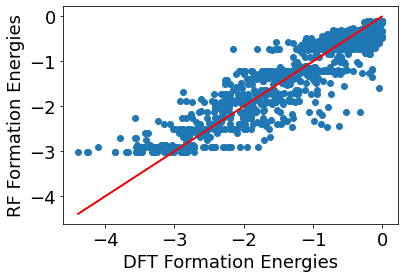

In [10]:
#Plot the true versus predicted values
plt.figure()

plt.scatter(list(y_test), pred)
plt.plot(list(y_test), list(y_test), color = 'r')
plt.xlabel('DFT Formation Energies')
plt.ylabel('RF Formation Energies')

**Refine a Random Forest Model using a Hyperparameter Search**

This time, we will use the ``GridSearchCV`` method to both search the hyperparameter space and better evaluate the model performance.

Currently, we are just optimizing the ``n_estimators`` and ``max_depth``, however other hyperparameters can be included in the search as well.

Simultaneously, ``GridSearchCV`` performs cross-validation, which iteratively changes the the training-test split to evaluate how generality of the model perdictions results.

Here, we print out the optimized hyperparameters after the Grid Search as well as the performance error metrics evaluated using the test set.

**Try modifying**

1. Change method from ``GridSearchCV`` to ``RandomizedSearchCV`` and see note in the comments
2. Include additional hyperparameters in the search by uncommenting items in the ``param_space`` dictionary
3. Change the number of training-test cross-validation steps performed by changing the value of the ``cv`` parameter in the ``GridSearchCV`` function

In [11]:
# Hyperparameter optimization search for Magpie
X=X_Mag
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, random_state=1, test_size=0.1
)
model = RandomForestRegressor(random_state=1)
# Create a parameter grid. We will go over
# each possible combination of allowed parameters in the grid.
param_space = {
    "n_estimators": [2, 3, 4, 5],
    # "max_features"      : [ 0.4, 0.6,0.8,1], #,
    "max_depth": [2, 3, 4, 5, 10, 50],
    # 'min_samples_split':range(2, 6, 2)
    # "bootstrap": [True, False]
}

# Create a grid search cross validation model.
# It performs 5 fold cross validation by default.

'''
NOTE: If using RandomizedSearch, rename "param_grid" parameter name to 
"param_distributions"
'''
cross_val_obj = GridSearchCV(
    model, param_grid=param_space, n_jobs=-1, cv=5, return_train_score=True
)
# Perform the cross validation using our train data.
cross_val_obj.fit(X_train, y_train)
# Select the trained tree that did the best in the cross
# validation.
best_regressor = cross_val_obj.best_estimator_
print(
    "The model with the best score from CV is %.3f" % cross_val_obj.best_score_
)
print(
    "The best param(s) for the CV search is/are %s"
    % cross_val_obj.best_params_
)
print(
    "The model with the best R2 from CV is %.3f"
    % r2_score(list(y_test), best_regressor.predict(X_test))
)


# Now test this model on our validation dataset
# which haven't yet exposed to our model.
predictions_list = best_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(list(y_test), predictions_list))
mae = mean_absolute_error(list(y_test), predictions_list)
r2 = r2_score(list(y_test), predictions_list)
print(
    " The root mean squared error for the regressor found by CV is: %.3f"
    % rmse
)
print(" The mean absolute error for the regressor found by CV is: %.3f" % mae)
print(" The R2 for the regressor found by CV is: %.3f" % r2)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


The model with the best score from CV is 0.924
The best param(s) for the CV search is/are {'n_estimators': 5, 'max_depth': 10}
The model with the best R2 from CV is 0.938
 The root mean squared error for the regressor found by CV is: 0.220
 The mean absolute error for the regressor found by CV is: 0.158
 The R2 for the regressor found by CV is: 0.938


Text(0, 0.5, 'RF Formation Energies')

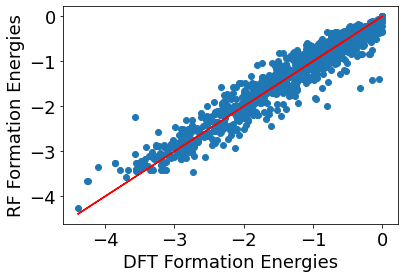

In [12]:
#Plot the true versus predicted values
plt.figure()

plt.scatter(list(y_test), predictions_list)
plt.plot(list(y_test), list(y_test), color = 'r')
plt.xlabel('DFT Formation Energies')
plt.ylabel('RF Formation Energies')

Here, we show the 10 features which most influence the regression model results.

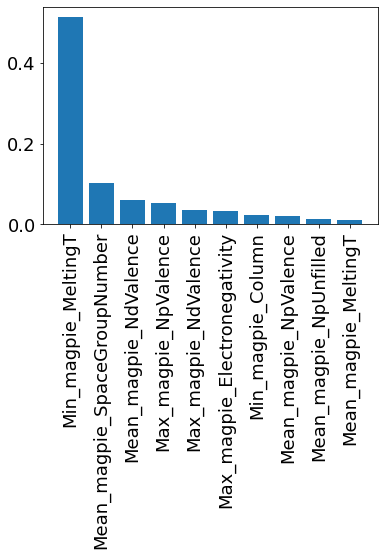

In [13]:
# Feature importance
f_names = np.array(magpie_names)
importances = best_regressor.feature_importances_
order = np.argsort(importances)[::-1]
numb_feats=10
plt.bar(np.arange(0,numb_feats),importances[order][0:numb_feats])
plt.xticks(np.arange(0,numb_feats),f_names[order][0:numb_feats],rotation=90)
f_names[order][0:numb_feats]
plt.rcParams.update({'font.size': 24})